# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Importing libraries and load datasets

In [86]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
import matplotlib.pyplot as plt
import math
import json

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data exploration and cleaning

### Portfolio data

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**Data cleaning**
* Expand values in `channels` column into new column
* Rename column `id` to `offer_id`
* Encode `offer_id` column as increasing number from 0 to 9
* Expand `offer_type` columns

In [87]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


Types of channels

In [88]:
print(portfolio["channels"].explode().unique())

['email' 'mobile' 'social' 'web']


DataFrame overview

In [89]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 612.0+ bytes


In [90]:
offer_type_dummy = pd.get_dummies(portfolio["offer_type"])

mlb = MultiLabelBinarizer()
channel_encoded = mlb.fit_transform(portfolio['channels'])

channel_dummy = pd.DataFrame(channel_encoded, columns=mlb.classes_)

portfolio = pd.concat([portfolio, offer_type_dummy, channel_dummy], axis=1)
portfolio.drop(columns=["offer_type", "channels"], inplace=True)
portfolio.rename(columns={ "id" : "offer_id" }, inplace=True)

**Encode offer-id as increasing number from 0**

In [91]:
offer_id_encoded = {key: i for i, key in enumerate(portfolio["offer_id"].unique())}
portfolio["offer_id"] = portfolio["offer_id"].replace(offer_id_encoded)

In [92]:
portfolio.head()

,reward,difficulty,duration,offer_id,bogo,discount,informational,email,mobile,social,web
0,10,10,7,0,True,False,False,1,1,1,0
1,10,10,5,1,True,False,False,1,1,1,1
2,0,0,4,2,False,False,True,1,1,0,1
3,5,5,7,3,True,False,False,1,1,0,1
4,5,20,10,4,False,True,False,1,0,0,1


### Profile data

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**Data cleaning**
* Encode `gender` as number from 0 to 2.
* Format `became_member_on` to date object.
* Drop user whose income is `NaN`
* Rename column `id` to `customer_id`

In [93]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [94]:
# Mapping dictionary
gender_mapping = {'F': 0, 'M': 1, 'O': 2}

In [95]:
profile.dropna(subset=["income"], inplace=True)
profile["became_member_on"] = pd.to_datetime(profile["became_member_on"], format="%Y%m%d")
#cleaned_profile["member_days"] = (pd.Timestamp('today') - cleaned_profile["became_member_on"]).dt.days

# profile["gender"] = profile["gender"].replace(gender_mapping)
profile.rename(columns={"id": "customer_id"}, inplace=True)

In [96]:
profile.head()

,gender,age,customer_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [97]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  int64         
 2   customer_id       14825 non-null  object        
 3   became_member_on  14825 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 694.9+ KB


**Gender distribution**

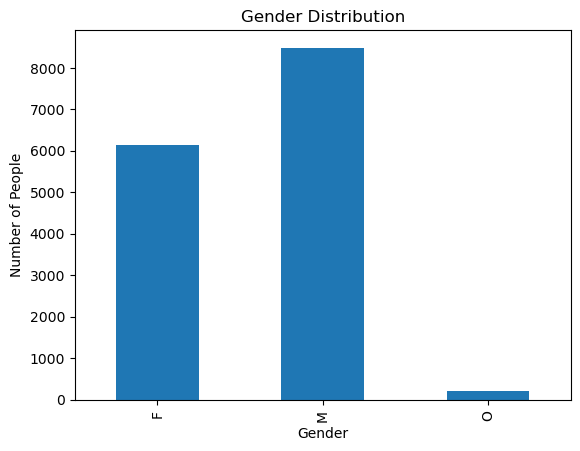

In [98]:
profile["gender"].value_counts().sort_index().plot(kind='bar')
plt.ylabel('Number of People')
plt.xlabel('Gender')
plt.title('Gender Distribution');

In [99]:
profile["gender"].value_counts()

gender
M    8484
F    6129
O     212
Name: count, dtype: int64

In [100]:
profile["gender"].value_counts(normalize=True).rename()

gender
M    0.572277
F    0.413423
O    0.014300
dtype: float64

**Age Distribution**

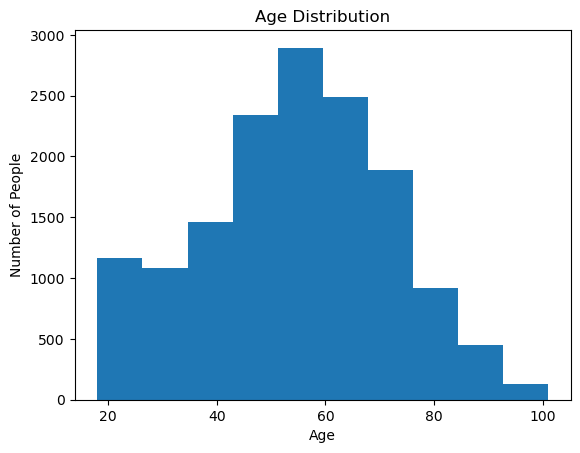

In [101]:
profile["age"].plot(kind='hist', bins=10)
plt.ylabel('Number of People')
plt.xlabel('Age')
plt.title('Age Distribution');

**Income Distribution**

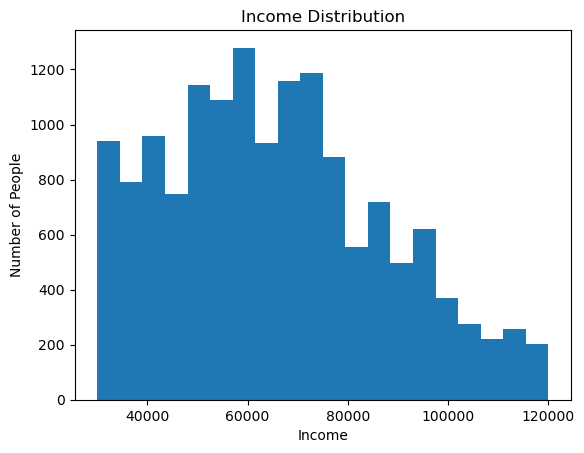

In [102]:
profile["income"].plot(kind='hist', bins=20)
plt.ylabel('Number of People')
plt.xlabel('Income')
plt.title('Income Distribution');

**Number of user registration by year**

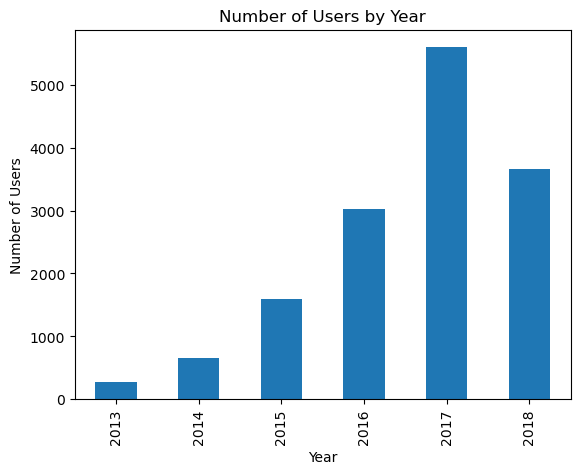

In [103]:
profile['became_member_on'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of Users')
plt.title('Number of Users by Year')
plt.show()

### Transcript data

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


**Data cleaning**
* Split dataframe into 2 smaller dataframes `transactions` and `offer_events`.
* Rename column `person` to `customer_id`
* For `transactions` dataframe, add column `offer_id` based on field in column `value`
* For `offer_events` dataframe, add column `amount` based on field in column `value`

In [104]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [105]:
transcript.rename(columns={"person": "customer_id"}, inplace=True)

**Types of events**

In [106]:
transcript["event"].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [107]:
offer_events = transcript[transcript["event"].str.contains("offer")]
transactions = transcript[transcript["event"] == "transaction"]

**Create offer_events dataframe from transcript**

In [108]:
offer_events["offer_id"] = offer_events["value"].apply(lambda x: x["offer id"] if "offer id" in x else x["offer_id"])

offer_events["event"] = offer_events["event"].apply(lambda x: x.split(' ')[1])
offer_events["offer_id"] = offer_events["offer_id"].replace(offer_id_encoded)
offer_events.drop(columns="value", inplace=True)

C:\Users\luong\AppData\Local\Temp\ipykernel_6128\36176571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_events["offer_id"] = offer_events["value"].apply(lambda x: x["offer id"] if "offer id" in x else x["offer_id"])
C:\Users\luong\AppData\Local\Temp\ipykernel_6128\36176571.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  offer_events["event"] = offer_events["event"].apply(lambda x: x.split(' ')[1])
C:\Users\luong\AppData\Local\Temp\ipykernel_6128\36176571.py:4: SettingWithCopyWarning: 
A valu

In [109]:
offer_events.head()

,customer_id,event,time,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,received,0,3
1,a03223e636434f42ac4c3df47e8bac43,received,0,4
2,e2127556f4f64592b11af22de27a7932,received,0,9
3,8ec6ce2a7e7949b1bf142def7d0e0586,received,0,6
4,68617ca6246f4fbc85e91a2a49552598,received,0,1


**Create transaction dataframe from transcript**

In [110]:
transactions.head()

,customer_id,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


In [111]:
transactions.drop(columns="event", inplace=True)

transactions["amount"] = transactions["value"].apply(lambda x: x['amount'])
transactions.drop(columns="value", inplace=True)

C:\Users\luong\AppData\Local\Temp\ipykernel_6128\1428642372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions.drop(columns="event", inplace=True)
C:\Users\luong\AppData\Local\Temp\ipykernel_6128\1428642372.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions["amount"] = transactions["value"].apply(lambda x: x['amount'])
C:\Users\luong\AppData\Local\Temp\ipykernel_6128\1428642372.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

In [112]:
transactions.head()

,customer_id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
12659,54890f68699049c2a04d415abc25e717,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


**Distribution of offer actions among users**

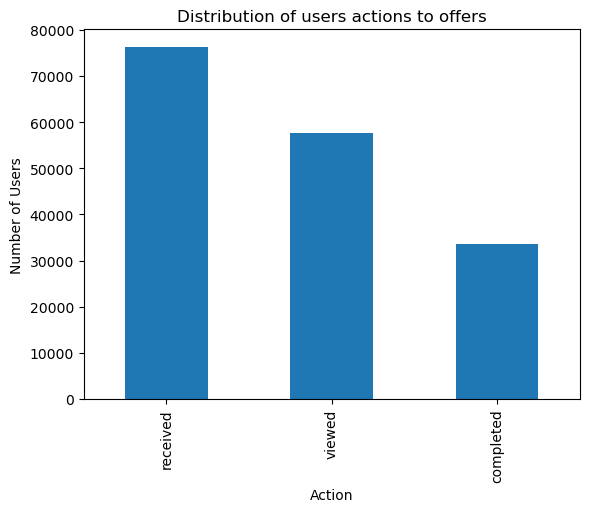

In [113]:
offer_events["event"].value_counts().plot(kind="bar")
plt.xlabel('Action')
plt.ylabel('Number of Users')
plt.title('Distribution of users actions to offers')
plt.show()

**Distribution of offer received id**

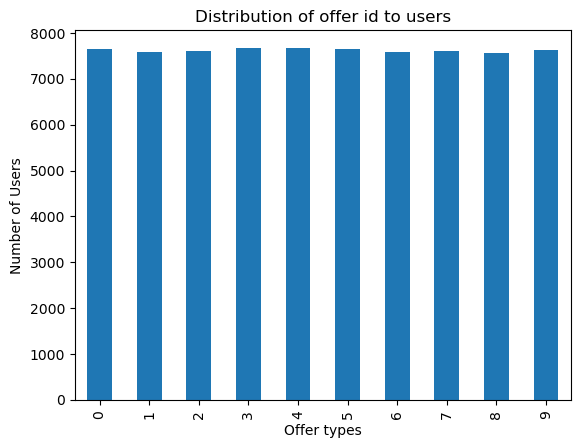

In [114]:
offer_events[offer_events["event"] == "received"]["offer_id"].value_counts().sort_index().plot(kind="bar")
plt.xlabel('Offer types')
plt.ylabel('Number of Users')
plt.title('Distribution of offer id to users')
plt.show()

### Combine data

In [115]:
profile["gender"] = profile["gender"].replace(gender_mapping)

In [116]:
df = offer_events.merge(portfolio, on="offer_id")

In [117]:
df.head()

,customer_id,event,time,offer_id,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,received,0,3,5,5,7,True,False,False,1,1,0,1
1,ebe7ef46ea6f4963a7dd49f501b26779,received,0,3,5,5,7,True,False,False,1,1,0,1
2,f082d80f0aac47a99173ba8ef8fc1909,received,0,3,5,5,7,True,False,False,1,1,0,1
3,c0d210398dee4a0895b24444a5fcd1d2,received,0,3,5,5,7,True,False,False,1,1,0,1
4,57dd18ec5ddc46828afb81ec5977bef2,received,0,3,5,5,7,True,False,False,1,1,0,1


**Distribution of Offer types**

In [118]:
def offer_type_dist(offer_type: str):
    received_df = df[df["event"] == offer_type]

    offer_received_dist = pd.DataFrame({
        "label": ["bogo", "discount", "informational"],
        "value": [(received_df["bogo"] == True).sum(), (received_df["discount"] == True).sum(),  (received_df["informational"] == True).sum()]
    })

    return offer_received_dist

In [119]:
offer_events_types = df["event"].unique()

event_dists = {event_type: offer_type_dist(event_type) for event_type in offer_events_types}

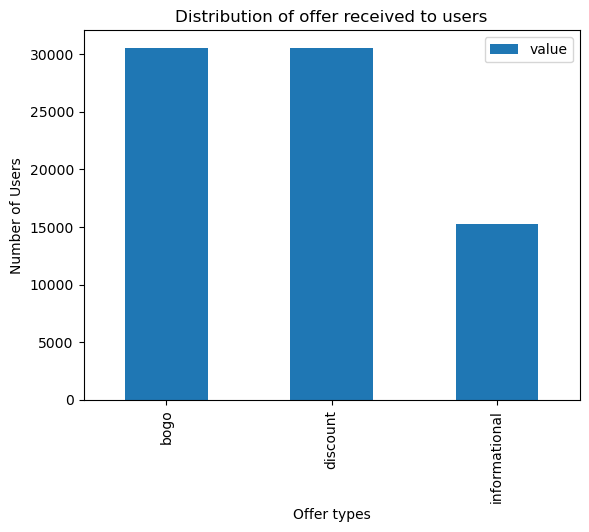

In [120]:
event_dists["received"].plot(kind="bar", x="label")
plt.xlabel('Offer types')
plt.ylabel('Number of Users')
plt.title('Distribution of offer received to users')
plt.show()

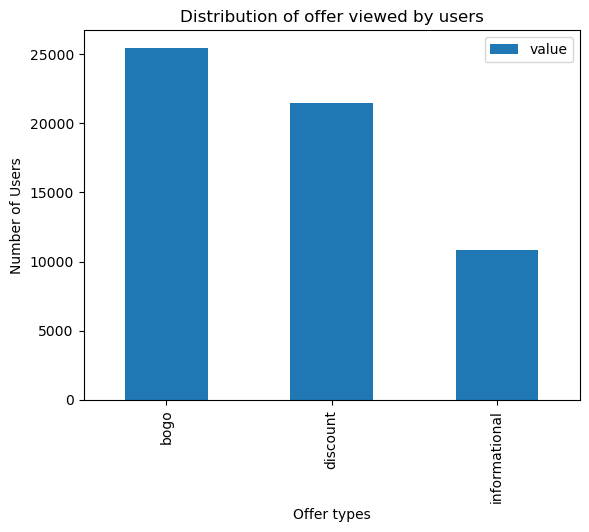

In [121]:
event_dists["viewed"].plot(kind="bar", x="label")
plt.xlabel('Offer types')
plt.ylabel('Number of Users')
plt.title('Distribution of offer viewed by users')
plt.show()

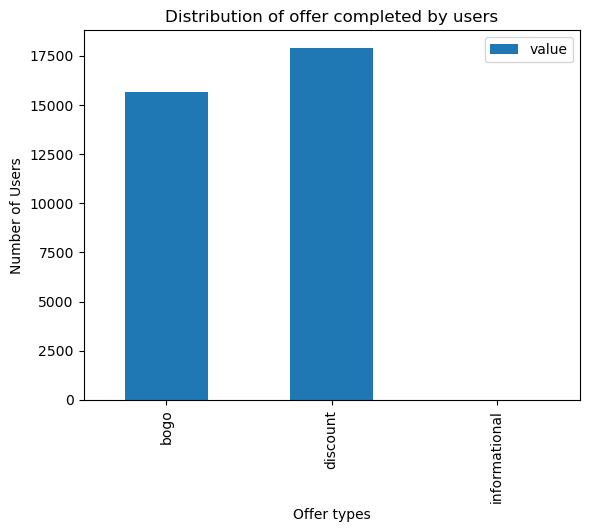

In [122]:
event_dists["completed"].plot(kind="bar", x="label")
plt.xlabel('Offer types')
plt.ylabel('Number of Users')
plt.title('Distribution of offer completed by users')
plt.show()

### Modeling and Prediction

**To identify the optimal binary classifier for this task, we'll evaluate a selection of popular models based on performance metrics. We'll then fine-tune the hyperparameters of the chosen model using GridSearchCV.**

**Models to be evaluated**
* Random Forest
* Decision tree
* Adaboost
* Naive Bayes

**Data preparation**
* Only keep the year for column `became_member_on`
* Drop column event
* Add additional column `successful` to determin the user will take the offer.
* Use MinMax scaler to scale down values between 0 and 1 as `income` column and `age` column seem to have values greater than other


**Metrics**
* Accuracy and F1-score will be the metrics used to assess the performance of four models.

In [123]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.naive_bayes import GaussianNB

In [124]:
event_encode = { key: idx for idx, key in enumerate(offer_events_types)}

In [125]:
df = df.merge(profile, on="customer_id").reset_index().drop(columns=["customer_id"])
# df["event"] = df["event"].replace(event_encode)
df["became_member_on"] = df["became_member_on"].dt.year

# add column completed
df["successful"] = df["event"].apply(lambda x: True if x == "completed" else False)
df = df.drop(columns=["event", "index"])

In [126]:
df.head()

,time,offer_id,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web,gender,age,became_member_on,income,successful
0,0,3,5,5,7,True,False,False,1,1,0,1,0,75,2017,100000.0,False
1,6,3,5,5,7,True,False,False,1,1,0,1,0,75,2017,100000.0,False
2,132,3,5,5,7,True,False,False,1,1,0,1,0,75,2017,100000.0,True
3,504,8,5,5,5,True,False,False,1,1,1,1,0,75,2017,100000.0,False
4,510,8,5,5,5,True,False,False,1,1,1,1,0,75,2017,100000.0,True


In [127]:
df["successful"].value_counts()

successful
False    116361
True      32444
Name: count, dtype: int64

**Standardization & Normalization**

Use minmax scaler to scales numerical features to a fixed range, typically between 0 and 1.

In [128]:
scaler = MinMaxScaler()

In [129]:
scaled_cols = [col for col in df.columns if col not in ["offer_id"]]

In [130]:
df[scaled_cols] = scaler.fit_transform(df[scaled_cols])

**Create train and test dataset**

In [131]:
X = df.drop(columns=["successful"])
y = df["successful"]

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [133]:
X_train.head()

,time,offer_id,reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web,gender,age,became_member_on,income
139528,0.571429,7,0.0,0.00,0.000000,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.397590,0.6,0.222222
145750,0.571429,5,0.3,0.35,0.571429,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.120482,0.8,0.300000
106173,0.050420,1,1.0,0.50,0.285714,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.337349,0.4,0.266667
74160,0.705882,6,0.2,0.50,1.000000,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.506024,0.6,0.577778
10391,0.319328,3,0.5,0.25,0.571429,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.409639,0.8,0.222222


In [134]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89283 entries, 139528 to 121958
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              89283 non-null  float64
 1   offer_id          89283 non-null  int64  
 2   reward            89283 non-null  float64
 3   difficulty        89283 non-null  float64
 4   duration          89283 non-null  float64
 5   bogo              89283 non-null  float64
 6   discount          89283 non-null  float64
 7   informational     89283 non-null  float64
 8   email             89283 non-null  float64
 9   mobile            89283 non-null  float64
 10  social            89283 non-null  float64
 11  web               89283 non-null  float64
 12  gender            89283 non-null  float64
 13  age               89283 non-null  float64
 14  became_member_on  89283 non-null  float64
 15  income            89283 non-null  float64
dtypes: float64(15), int64(1)
memory usage: 

In [135]:
y_train.head()

139528    0.0
145750    0.0
106173    1.0
74160     0.0
10391     1.0
Name: successful, dtype: float64

**Applying various classifiers on the dataset**

In [136]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Naive Bayes": GaussianNB(),
}

metrics = []

In [137]:
for key, val in classifiers.items():
    print("Applying " + key)

    clf = val.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    metric = {
        "Classifier": key,
        "Accuracy": accuracy_score(y_pred=y_pred, y_true=y_test),
        "F1 score": f1_score(y_pred, y_test)
    }

    print(classification_report(y_pred, y_test))

    metrics.append(metric)

Applying Random Forest
              precision    recall  f1-score   support

         0.0       0.90      0.81      0.85     51600
         1.0       0.24      0.39      0.30      7922

    accuracy                           0.75     59522
   macro avg       0.57      0.60      0.57     59522
weighted avg       0.81      0.75      0.78     59522

Applying Decision Tree
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85     46730
         1.0       0.47      0.47      0.47     12792

    accuracy                           0.77     59522
   macro avg       0.66      0.66      0.66     59522
weighted avg       0.77      0.77      0.77     59522

Applying AdaBoost


c:\Users\luong\anaconda3\envs\analysis\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.96      0.82      0.89     54429
         1.0       0.25      0.63      0.36      5093

    accuracy                           0.81     59522
   macro avg       0.60      0.73      0.62     59522
weighted avg       0.90      0.81      0.84     59522

Applying Naive Bayes
              precision    recall  f1-score   support

         0.0       0.19      1.00      0.32      9024
         1.0       1.00      0.26      0.41     50498

    accuracy                           0.37     59522
   macro avg       0.60      0.63      0.37     59522
weighted avg       0.88      0.37      0.40     59522



In [138]:
metrics = pd.DataFrame(metrics)

<Figure size 1000x600 with 0 Axes>

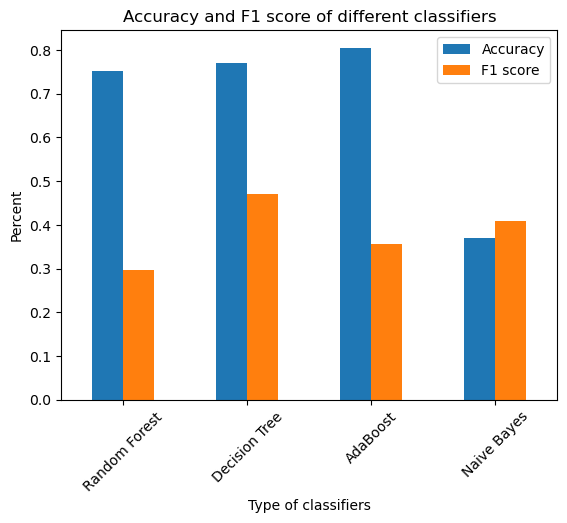

In [139]:
plt.figure(figsize=(10, 6))
metrics.plot(kind="bar", x="Classifier")
plt.xlabel('Type of classifiers')
plt.ylabel('Percent')
plt.title('Accuracy and F1 score of different classifiers')
plt.xticks(rotation=45)
plt.show()

In [140]:
metrics

,Classifier,Accuracy,F1 score
0,Random Forest,0.753217,0.295863
1,Decision Tree,0.770925,0.470094
2,AdaBoost,0.805316,0.357365
3,Naive Bayes,0.368990,0.407932


**Conclusion**

While AdaBoost achieved the highest accuracy, its F1-score suggests a potential bias towards a specific class. The Decision Tree, on the other hand, offers a more balanced performance with a respectable accuracy of 0.77 and a notable F1-score of 0.47. Considering this balance and its interpretability, we'll focus on fine-tuning the Decision Tree using GridSearchCV to potentially improve its accuracy while maintaining its class balance.

### Hyperparameter tuning

In [141]:
from sklearn.model_selection import GridSearchCV

In [142]:
param_grid = {
    'max_depth': [2, 4, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5)  # Adjust 'scoring' and 'cv' as needed

In [143]:
grid_search.fit(X_train, y_train)

c:\Users\luong\anaconda3\envs\analysis\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
135 fits failed out of a total of 405.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\luong\anaconda3\envs\analysis\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\luong\anaconda3\envs\analysis\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\luong\anaconda3\envs\analysis\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_const

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 4, 8],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [144]:
y_pred = grid_search.predict(X_test)

In [145]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88     58712
         1.0       0.04      0.58      0.07       810

    accuracy                           0.78     59522
   macro avg       0.51      0.68      0.47     59522
weighted avg       0.98      0.78      0.87     59522



**Conclusion**

- **Accuracy Improvement**: The overall accuracy of the decision tree model improved slightly from 0.770925 to 0.78 after applying GridSearchCV. This indicates that the hyperparameter tuning provided a marginal enhancement in correctly predicting the overall instances.

- **F1-Score Stability**: The macro average F1-score remained constant at 0.47, suggesting that the improvements in precision and recall for the individual classes balanced out overall, resulting in no net gain in the average F1-score.

In summary, while GridSearchCV has marginally improved the model's overall accuracy and significantly enhanced recall for the minority class, substantial challenges remain in improving the precision and overall detection of the minority class. Further efforts are needed to address these imbalances for a more robust model.

